In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
!nvidia-smi

Wed Mar 30 03:43:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    35W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import io
import glob
import random
import sys
import tensorflow as tf
import keras
import pandas as pd
from keras.layers import *
from keras.models import *
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from sklearn.model_selection import KFold
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# get file path
train_data_path = list()
label_data_path = list()
lane_status_path = list()
label_selfcreate_path = list()

with open('/content/drive/My Drive/CULane/train_gt.txt', 'r') as f: 
  for file in range (88880): #limit all - 88880 
    string = f.readline()
    # print(string[0:19])

    if string[0:19] == "/driver_161_90frame":

      line = f.readline().split(' ')
      line[-1] = line[-1].replace('\n', '')
  
      a = '/content/drive/My Drive/CULane'+line[0]
      b = '/content/drive/My Drive/CULane'+line[1]
      c = line[2:]

      d = a.replace('jpg', 'lines.txt')

      # Train_Dataset_path.append([train_data, label_data, lane_status])
      train_data_path.append(a)
      label_data_path.append(b)
      lane_status_path.append(c)
      label_selfcreate_path.append(d)

print(train_data_path)
print(label_data_path)
print(lane_status_path)
print(label_selfcreate_path)

['/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/00090.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/00270.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/00450.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/00630.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/00810.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/00990.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/01170.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/01350.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/01530.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/01710.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/01890.jpg', '/content/drive/My Drive/CULane/driver_161_90frame/06031222_0836.MP4/02070.jpg', '/content/drive/My Drive/CU

Data augmentation

In [7]:
def random_brightness (image, label):
  
  image = tf.image.stateless_random_brightness(image, max_delta=1, seed=seed)

  return image, label

In [8]:
def random_crop (image, label):

  image = tf.image.stateless_random_crop(image, size=[500, 500, 3], seed=seed)
  label = tf.image.stateless_random_crop(label, size=[500, 500], seed=seed)

  # crop in openCV
  # height, width = int(image.shape[0]*0.5), int(image.shape[1]*0.5)
  # x = random.randint(0, image.shape[1] - int(width))
  # y = random.randint(0, image.shape[0] - int(height))
  # cropped_image = image[y:y+height, x:x+width]
  # cropped_label = label[y:y+height, x:x+width]

  # return cropped_image, cropped_label
  return image, label

In [9]:
def flipped (image, label):

  image = tf.image.flip_left_right(image)
  label = cv2.flip(label, 1)

  return image, label

In [10]:
def binary_image(picture):

  for n in range(picture.shape[1]):     
    for m in range(picture.shape[0]):
      if picture[n,m] != 0:
        picture[n,m] = 255

  return picture

In [11]:
def resieze_normalization (image, label):
  image = cv2.resize(np.float32(image), (128, 128))
  label = cv2.resize(np.float32(label), (128, 128))

  label = binary_image(label)

  image = image / 255.0
  label = label / 255.0

  return image, label

In [12]:
def visualize(image, label):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('image')
  plt.imshow(image)

  plt.subplot(1,2,2)
  plt.title('label')
  plt.imshow(label)

In [13]:
# utlize label in dataset to load data 
images, labels = [], []

for i in range (2000):

  image = cv2.imread(train_data_path[i],1)  # Reading Image in RGB format
  label = cv2.imread(label_data_path[i],0)
  # visualize(image, label)

  number = random.randint(1, 3)
  seed = (number, 0) 
  seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  image_bringtness,label_bringtness = random_brightness (image, label)
  image_crop,label_crop = random_crop (image, label)
  image_flipped,label_flipped = flipped (image, label)

  # visualize(image_bringtness, label_bringtness)
  # visualize(image_crop, label_crop)
  # visualize(image_flipped, label_flipped)
    
  image_bringtness,label_bringtness = resieze_normalization (image, label)
  image_crop,label_crop = resieze_normalization (image, label)
  image_flipped,label_flipped = resieze_normalization (image, label)

  images.append(image_bringtness)
  labels.append(label_bringtness)
  images.append(image_crop)
  labels.append(label_crop)
  images.append(image_flipped)
  labels.append(label_flipped)

  image,label = resieze_normalization (image, label)

  images.append(image)
  labels.append(label)

images = np.array(images)
labels = np.array(labels)
print(images.shape)
print(type(images))
print(labels.shape)
print(type(labels))
# # The resolution of orignal individual image is : 1640x590.

(8000, 128, 128, 3)
<class 'numpy.ndarray'>
(8000, 128, 128)
<class 'numpy.ndarray'>


Tranning

In [14]:
# split data
X_train,X_test,y_train,y_test=train_test_split(images,labels,test_size=0.1,random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.25,random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

In [15]:
def build_model(input_layer, start_neurons):
     # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((128, 128, 3))
output_layer = build_model(input_layer, 16)#16

In [16]:
model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [17]:
# train model
history = model.fit(X_train, y_train, batch_size = 32, epochs = 100, verbose=1, shuffle=False, validation_data=(X_val, y_val))
model.evaluate(X_test, y_test)

Epoch 1/100
169/169 [==============================] - 22s 61ms/step - loss: 0.1313 - accuracy: 0.9714 - val_loss: 0.0890 - val_accuracy: 0.9716
Epoch 2/100
169/169 [==============================] - 9s 55ms/step - loss: 0.0821 - accuracy: 0.9719 - val_loss: 0.0788 - val_accuracy: 0.9716
Epoch 3/100
169/169 [==============================] - 9s 55ms/step - loss: 0.0749 - accuracy: 0.9720 - val_loss: 0.0691 - val_accuracy: 0.9726
Epoch 4/100
169/169 [==============================] - 9s 55ms/step - loss: 0.0683 - accuracy: 0.9734 - val_loss: 0.0613 - val_accuracy: 0.9761
Epoch 5/100
169/169 [==============================] - 9s 55ms/step - loss: 0.0603 - accuracy: 0.9767 - val_loss: 0.0569 - val_accuracy: 0.9776
Epoch 6/100
169/169 [==============================] - 9s 55ms/step - loss: 0.0553 - accuracy: 0.9787 - val_loss: 0.0499 - val_accuracy: 0.9807
Epoch 7/100
169/169 [==============================] - 9s 55ms/step - loss: 0.0511 - accuracy: 0.9803 - val_loss: 0.0470 - val_accuracy

[0.008143500424921513, 0.9965643882751465]

Validation

In [18]:
# Plot history: loss
def loss_plot ():
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [19]:
# Plot history: Accuracy
def Accuracy_plot ():
  plt.plot(history.history['val_accuracy'])
  plt.title('Validation accuracy history')
  plt.ylabel('Accuracy value (%)')
  plt.xlabel('No. epoch')
  plt.show()

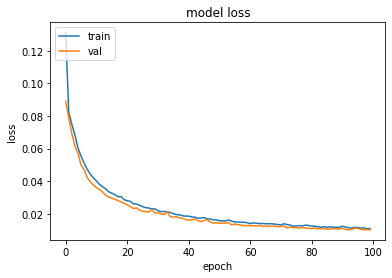

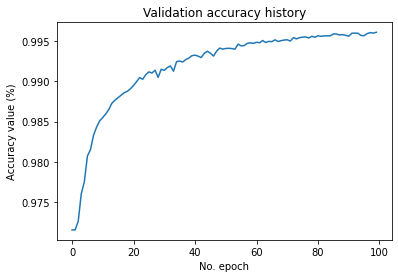

In [20]:
loss_plot ()
Accuracy_plot ()

Visualize reuslt

In [21]:
predict = model.predict(X_test)
print(predict.shape)
print(predict.dtype)
print(images.dtype)
print(images.dtype)
# from scipy import stats
# stats.describe(predict)

(800, 128, 128, 1)
float32
float32
float32


In [22]:
# remove normarlization
image_example = X_test*255
label_example = y_test*255
label_predict = predict*255


In [23]:
label_predict.shape

(800, 128, 128, 1)

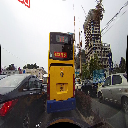

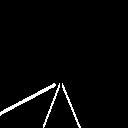

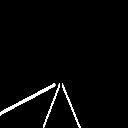

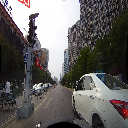

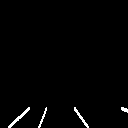

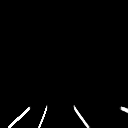

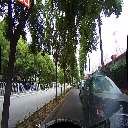

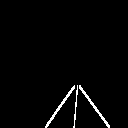

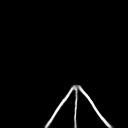

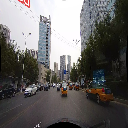

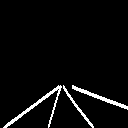

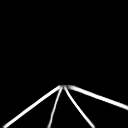

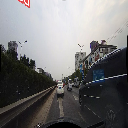

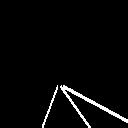

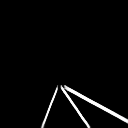

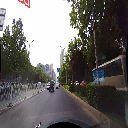

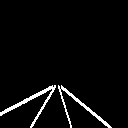

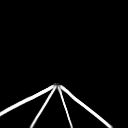

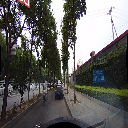

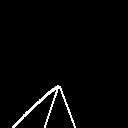

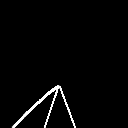

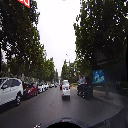

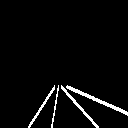

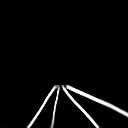

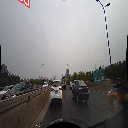

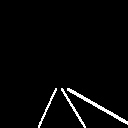

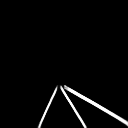

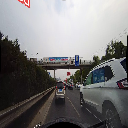

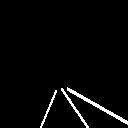

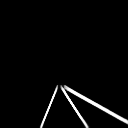

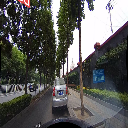

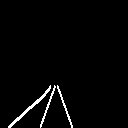

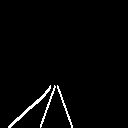

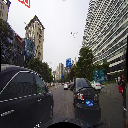

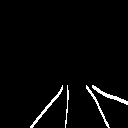

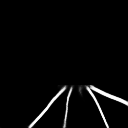

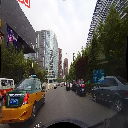

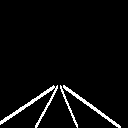

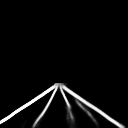

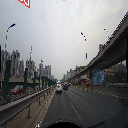

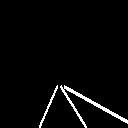

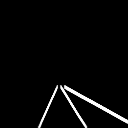

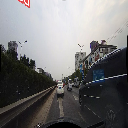

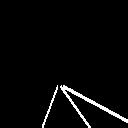

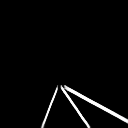

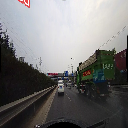

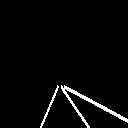

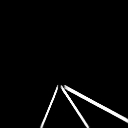

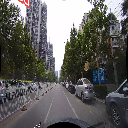

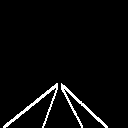

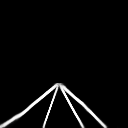

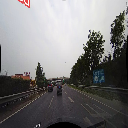

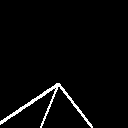

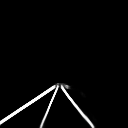

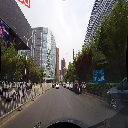

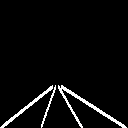

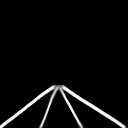

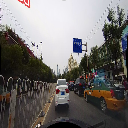

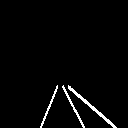

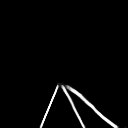

In [24]:
# display result
for n in range(20):
  cv2_imshow(image_example[n,:,:,:])
  cv2_imshow(label_example[n,:,:])
  cv2_imshow(label_predict[n,:,:,:])

Cross validation

In [25]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, random_state=None, shuffle=True)
fold_no = 1

acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/60
152/152 [==============================] - 9s 61ms/step - loss: 0.0108 - accuracy: 0.9954 - val_loss: 0.0102 - val_accuracy: 0.9960
Epoch 2/60
152/152 [==============================] - 8s 56ms/step - loss: 0.0106 - accuracy: 0.9955 - val_loss: 0.0098 - val_accuracy: 0.9963
Epoch 3/60
152/152 [==============================] - 9s 57ms/step - loss: 0.0109 - accuracy: 0.9954 - val_loss: 0.0101 - val_accuracy: 0.9960
Epoch 4/60
152/152 [==============================] - 8s 56ms/step - loss: 0.0107 - accuracy: 0.9955 - val_loss: 0.0098 - val_accuracy: 0.9961
Epoch 5/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0107 - accuracy: 0.9955 - val_loss: 0.0102 - val_accuracy: 0.9960
Epoch 6/60
152/152 [==============================] - 8s 56ms/step - loss: 0.0105 - accuracy: 0.9956 - val_loss: 0.0101 - val_accuracy: 0.9961
Epoch 7/60
152/152 [=========================

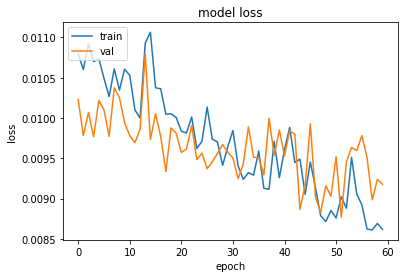

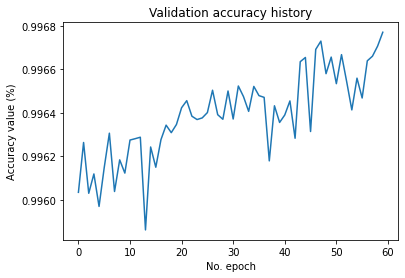

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/60
152/152 [==============================] - 9s 58ms/step - loss: 0.0090 - accuracy: 0.9963 - val_loss: 0.0084 - val_accuracy: 0.9968
Epoch 2/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0087 - accuracy: 0.9964 - val_loss: 0.0087 - val_accuracy: 0.9968
Epoch 3/60
152/152 [==============================] - 8s 56ms/step - loss: 0.0090 - accuracy: 0.9963 - val_loss: 0.0083 - val_accuracy: 0.9969
Epoch 4/60
152/152 [==============================] - 8s 56ms/step - loss: 0.0094 - accuracy: 0.9961 - val_loss: 0.0090 - val_accuracy: 0.9965
Epoch 5/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0092 - accuracy: 0.9962 - val_loss: 0.0090 - val_accuracy: 0.9966
Epoch 6/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0089 - accuracy: 0.9963 - val_loss: 0.0084 - val_accuracy: 0.9969
Epoch 7/60
152/152 [=========================

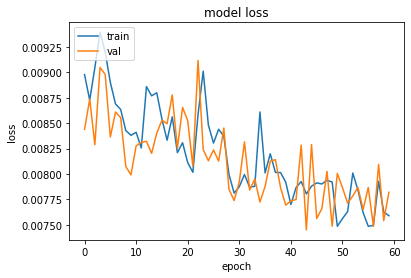

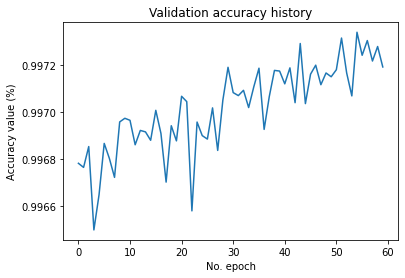

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/60
152/152 [==============================] - 9s 58ms/step - loss: 0.0078 - accuracy: 0.9968 - val_loss: 0.0077 - val_accuracy: 0.9971
Epoch 2/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0075 - accuracy: 0.9969 - val_loss: 0.0074 - val_accuracy: 0.9974
Epoch 3/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0075 - accuracy: 0.9969 - val_loss: 0.0073 - val_accuracy: 0.9974
Epoch 4/60
152/152 [==============================] - 8s 56ms/step - loss: 0.0075 - accuracy: 0.9969 - val_loss: 0.0073 - val_accuracy: 0.9974
Epoch 5/60
152/152 [==============================] - 8s 56ms/step - loss: 0.0074 - accuracy: 0.9969 - val_loss: 0.0073 - val_accuracy: 0.9973
Epoch 6/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0082 - accuracy: 0.9967 - val_loss: 0.0073 - val_accuracy: 0.9973
Epoch 7/60
152/152 [=========================

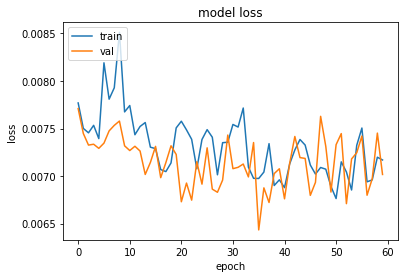

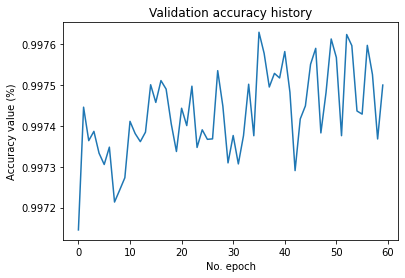

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/60
152/152 [==============================] - 9s 57ms/step - loss: 0.0070 - accuracy: 0.9971 - val_loss: 0.0065 - val_accuracy: 0.9975
Epoch 2/60
152/152 [==============================] - 8s 56ms/step - loss: 0.0069 - accuracy: 0.9971 - val_loss: 0.0070 - val_accuracy: 0.9976
Epoch 3/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0070 - accuracy: 0.9971 - val_loss: 0.0069 - val_accuracy: 0.9976
Epoch 4/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0071 - accuracy: 0.9971 - val_loss: 0.0070 - val_accuracy: 0.9976
Epoch 5/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0071 - accuracy: 0.9971 - val_loss: 0.0075 - val_accuracy: 0.9973
Epoch 6/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0070 - accuracy: 0.9971 - val_loss: 0.0069 - val_accuracy: 0.9976
Epoch 7/60
152/152 [=========================

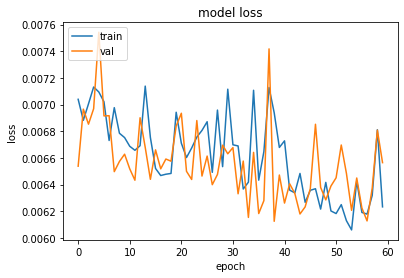

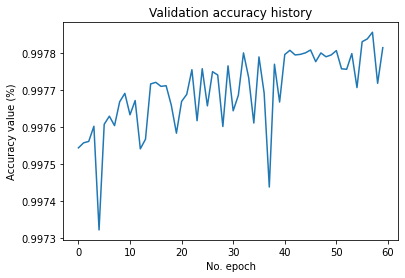

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/60
152/152 [==============================] - 9s 57ms/step - loss: 0.0066 - accuracy: 0.9973 - val_loss: 0.0063 - val_accuracy: 0.9978
Epoch 2/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0065 - accuracy: 0.9973 - val_loss: 0.0061 - val_accuracy: 0.9978
Epoch 3/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0063 - accuracy: 0.9974 - val_loss: 0.0065 - val_accuracy: 0.9977
Epoch 4/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0063 - accuracy: 0.9974 - val_loss: 0.0066 - val_accuracy: 0.9978
Epoch 5/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0063 - accuracy: 0.9974 - val_loss: 0.0066 - val_accuracy: 0.9977
Epoch 6/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0065 - accuracy: 0.9973 - val_loss: 0.0061 - val_accuracy: 0.9978
Epoch 7/60
152/152 [=========================

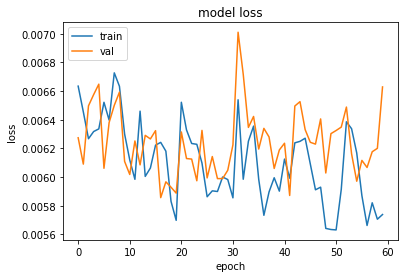

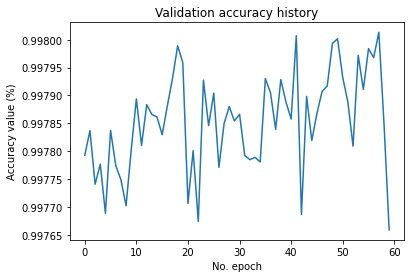

------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/60
152/152 [==============================] - 9s 58ms/step - loss: 0.0063 - accuracy: 0.9975 - val_loss: 0.0060 - val_accuracy: 0.9979
Epoch 2/60
152/152 [==============================] - 9s 57ms/step - loss: 0.0068 - accuracy: 0.9973 - val_loss: 0.0063 - val_accuracy: 0.9977
Epoch 3/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0064 - accuracy: 0.9974 - val_loss: 0.0064 - val_accuracy: 0.9979
Epoch 4/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0059 - accuracy: 0.9976 - val_loss: 0.0061 - val_accuracy: 0.9979
Epoch 5/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0058 - accuracy: 0.9976 - val_loss: 0.0062 - val_accuracy: 0.9980
Epoch 6/60
152/152 [==============================] - 8s 56ms/step - loss: 0.0058 - accuracy: 0.9976 - val_loss: 0.0061 - val_accuracy: 0.9980
Epoch 7/60
152/152 [=========================

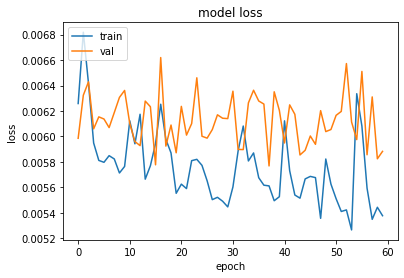

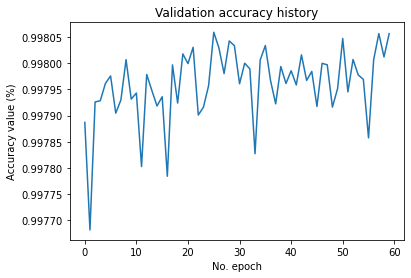

------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/60
152/152 [==============================] - 9s 58ms/step - loss: 0.0060 - accuracy: 0.9976 - val_loss: 0.0062 - val_accuracy: 0.9979
Epoch 2/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0057 - accuracy: 0.9977 - val_loss: 0.0057 - val_accuracy: 0.9979
Epoch 3/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0056 - accuracy: 0.9977 - val_loss: 0.0059 - val_accuracy: 0.9980
Epoch 4/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0057 - accuracy: 0.9977 - val_loss: 0.0059 - val_accuracy: 0.9980
Epoch 5/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0055 - accuracy: 0.9977 - val_loss: 0.0060 - val_accuracy: 0.9979
Epoch 6/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0056 - accuracy: 0.9977 - val_loss: 0.0060 - val_accuracy: 0.9980
Epoch 7/60
152/152 [=========================

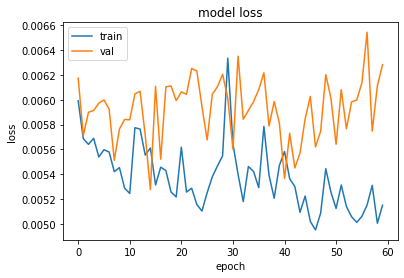

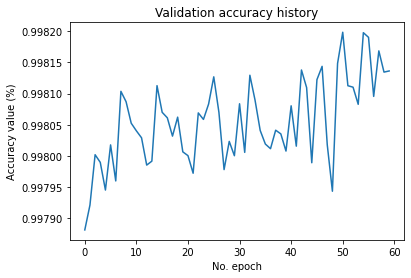

------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/60
152/152 [==============================] - 9s 57ms/step - loss: 0.0054 - accuracy: 0.9978 - val_loss: 0.0059 - val_accuracy: 0.9980
Epoch 2/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0060 - accuracy: 0.9976 - val_loss: 0.0062 - val_accuracy: 0.9979
Epoch 3/60
152/152 [==============================] - 9s 57ms/step - loss: 0.0057 - accuracy: 0.9977 - val_loss: 0.0059 - val_accuracy: 0.9979
Epoch 4/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0057 - accuracy: 0.9977 - val_loss: 0.0054 - val_accuracy: 0.9981
Epoch 5/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0060 - accuracy: 0.9976 - val_loss: 0.0058 - val_accuracy: 0.9979
Epoch 6/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0056 - accuracy: 0.9977 - val_loss: 0.0057 - val_accuracy: 0.9981
Epoch 7/60
152/152 [=========================

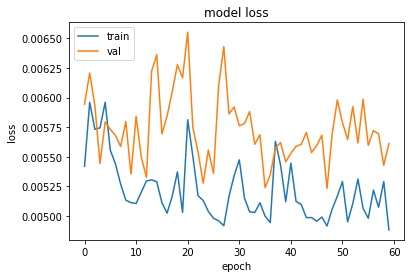

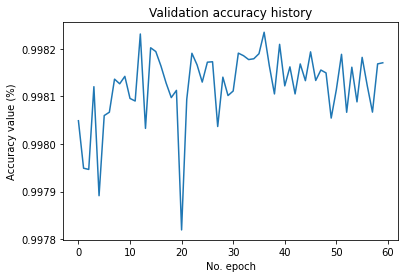

------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/60
152/152 [==============================] - 9s 58ms/step - loss: 0.0052 - accuracy: 0.9979 - val_loss: 0.0056 - val_accuracy: 0.9982
Epoch 2/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0052 - accuracy: 0.9979 - val_loss: 0.0058 - val_accuracy: 0.9981
Epoch 3/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0059 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 0.9981
Epoch 4/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0056 - accuracy: 0.9977 - val_loss: 0.0057 - val_accuracy: 0.9980
Epoch 5/60
152/152 [==============================] - 8s 56ms/step - loss: 0.0053 - accuracy: 0.9978 - val_loss: 0.0058 - val_accuracy: 0.9981
Epoch 6/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0053 - accuracy: 0.9979 - val_loss: 0.0059 - val_accuracy: 0.9981
Epoch 7/60
152/152 [=========================

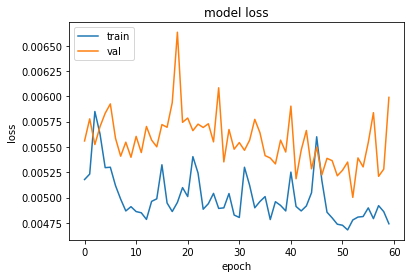

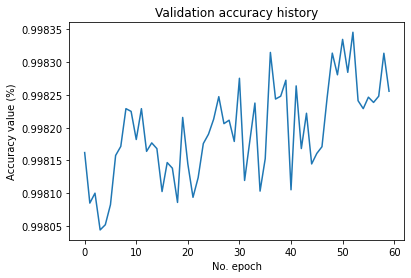

------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/60
152/152 [==============================] - 9s 58ms/step - loss: 0.0048 - accuracy: 0.9980 - val_loss: 0.0053 - val_accuracy: 0.9983
Epoch 2/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0053 - accuracy: 0.9979 - val_loss: 0.0056 - val_accuracy: 0.9980
Epoch 3/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0050 - accuracy: 0.9980 - val_loss: 0.0050 - val_accuracy: 0.9983
Epoch 4/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0048 - accuracy: 0.9980 - val_loss: 0.0056 - val_accuracy: 0.9982
Epoch 5/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0051 - accuracy: 0.9979 - val_loss: 0.0056 - val_accuracy: 0.9982
Epoch 6/60
152/152 [==============================] - 9s 56ms/step - loss: 0.0049 - accuracy: 0.9980 - val_loss: 0.0054 - val_accuracy: 0.9983
Epoch 7/60
152/152 [========================

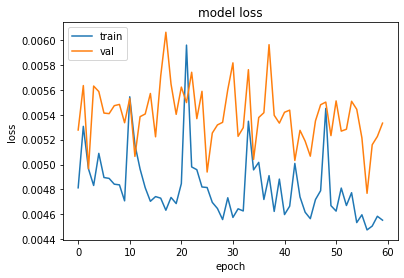

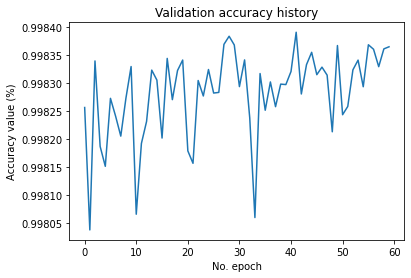

In [26]:
for train, test in kfold.split(X_train, y_train):
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(X_train[train], y_train[train], batch_size = 32, epochs = 60, verbose=1, shuffle=False, validation_data=(X_val, y_val))

  # Generate generalization metrics
  scores = model.evaluate(X_train[test], y_train[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

  loss_plot ()
  Accuracy_plot ()

In [27]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.00783457886427641 - Accuracy: 99.70378875732422%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.006026173941791058 - Accuracy: 99.75748658180237%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.0049124001525342464 - Accuracy: 99.80136156082153%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.0036412340123206377 - Accuracy: 99.85570907592773%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.004585319198668003 - Accuracy: 99.81666803359985%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.003570755710825324 - Accuracy: 99.85775351524353%
-----------------------------------------------------------